# Red Generativa Adversaria

Creación de números escritos a mano usando MNIST, hecho por Alba Reinders Sánchez y Alejandro Valverde Mahou, siguiendo el siguiete [tutorial](https://www.tensorflow.org/tutorials/generative/dcgan)

## ¿Qué es una red generativa adversaria?

Las redes generativas adversarias (*GANs*) consisten en dos redes enfrentadas entre ellas, de forma que la primera intenta generar imágenes que la segunda reconozca como reales y no como generedas. Mientras que la segunda intenta lo contrario.

![image.png](https://www.tensorflow.org/tutorials/generative/images/gan2.png)

Este tutorial consiste en generar imágenes de números escritos a mano usando el dataset MNIST.

## Imports

In [6]:
import tensorflow as tf

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

## Preparación del dataset

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], train_images.shape[1], train_images.shape[2], 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalizar las imágener a [-1, 1]

# Batch y mezcla de los datos
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


## Crear el modelo

### Modelo Generador

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) 

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


#### Generar imagen sin entrenar el modelo

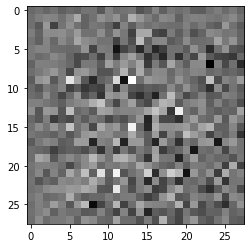

In [10]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Modelo Discriminador

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00126039]], shape=(1, 1), dtype=float32)


## Definir las funciones de coste y los optimizadores 

In [13]:
# Función auxiliar para la 'cross entropy'
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Función de coste del discriminador

Este método cuantifica cómo de bien es capaz el discriminador de distinguir entre imágenes reales y generadas. Para ello, compara la salida de la predicción de las imágenes reales con un array de 1s y la predicción de imágenes generadas con un array de 0s, y lo suma todo.

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Función de coste del generador

Este método cuantifica si el generador es capaz de engañar al discriminador. Si el generador lo está haciendo bien, el discriminador clasificará las imágenes generadas como reales (1s).

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Optimizadores

Cada red tiene que tener su optimizador.

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Checkpoints

Los checkpoints son necesarios para guardar el progreso del entrenamiento y poder restaurarlo en caso de que se vea interrumpido.

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Bucle de entrenamiento

In [18]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

El bucle de entrenamiento comienza con el generador recibiendo una 'seed' como input. Esa 'seed' se utiliza para generar una imagen. Después el discriminador se usa para clasificar imágenes reales e imágenes falsas.

Se calcula la función de coste para cada uno de los modelos y se utilizan los gradientes para actualizar ambos modelos.

In [19]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [20]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Producir imágenes para el GIF
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Guardar el modelo cada 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generar después del último epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                               epochs,
                               seed)

In [21]:
# Generar y guardar imágenes
def generate_and_save_images(model, epoch, test_input):
    
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Entrenar el modelo

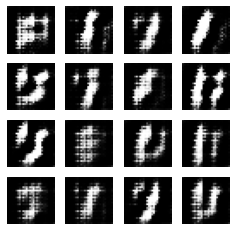

Time for epoch 3 is 364.00766110420227 sec


KeyboardInterrupt: 

In [21]:
train(train_dataset, EPOCHS)